In [1]:
!pip install timm torch torchvision

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split
from torchvision import models
import warnings
import sys
from tqdm import tqdm
import time
import copy
import timm
from timm.loss.binary_cross_entropy import BinaryCrossEntropy
warnings.filterwarnings("ignore")

In [3]:
def get_data_loaders(batch_size, train=False):
    if train:
        # Image augmentation for train data
        transform = T.Compose([
            T.RandomHorizontalFlip(p=0.5),
            T.ColorJitter(brightness=0.05, contrast=0.05),
            T.Resize(224),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),  # ImageNet mean and stdev
            T.RandomErasing(p=0.05, value='random')
        ])
        
        train_data_path = '/kaggle/input/cropped-and-balanced-openforensics-data/train_cropped_faces_224_rgb_balanced/Train'
        train_data = datasets.ImageFolder(train_data_path, transform = transform)
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return train_loader, train_data
    else:
        # No image augmentation for val and test data
        transform = T.Compose([
            T.Resize(224),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # ImageNet mean and stdev
        ])
        
        val_data_path = '/kaggle/input/cropped-and-balanced-openforensics-data/val_cropped_faces_224_rgb/Val'
        test_data_path = '/kaggle/input/cropped-and-balanced-openforensics-data/test_cropped_faces_224_rgb/Test'
        
        val_data = datasets.ImageFolder(val_data_path, transform=transform)
        test_data = datasets.ImageFolder(test_data_path, transform=transform)
        
        val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=4)
        test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4)
        return val_loader, test_loader, val_data, test_data

In [4]:
(train_loader, train_data) = get_data_loaders(batch_size=128, train=True)
(val_loader, test_loader, val_data, test_data) = get_data_loaders(batch_size=32, train=False)

In [5]:
print(train_data.class_to_idx)
print(val_data.class_to_idx)
print(test_data.class_to_idx)

{'Fake': 0, 'Real': 1}
{'Fake': 0, 'Real': 1}
{'Fake': 0, 'Real': 1}


In [6]:
dataloaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}
dataset_sizes = {
    'train': len(train_data),
    'val': len(val_data),
    'test': len(test_data)
}

In [7]:
print('Train, val, and test data size:')
dataset_sizes['train'], dataset_sizes['val'], dataset_sizes['test']

Train, val, and test data size:


(131720, 15345, 49718)

In [8]:
classes = ['Fake', 'Real']

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [10]:
timm.models.list_models('vit_*')

['vit_base_mci_224',
 'vit_base_patch8_224',
 'vit_base_patch14_dinov2',
 'vit_base_patch14_reg4_dinov2',
 'vit_base_patch16_18x2_224',
 'vit_base_patch16_224',
 'vit_base_patch16_224_miil',
 'vit_base_patch16_384',
 'vit_base_patch16_clip_224',
 'vit_base_patch16_clip_384',
 'vit_base_patch16_clip_quickgelu_224',
 'vit_base_patch16_gap_224',
 'vit_base_patch16_plus_240',
 'vit_base_patch16_plus_clip_240',
 'vit_base_patch16_reg4_gap_256',
 'vit_base_patch16_rope_reg1_gap_256',
 'vit_base_patch16_rpn_224',
 'vit_base_patch16_siglip_224',
 'vit_base_patch16_siglip_256',
 'vit_base_patch16_siglip_384',
 'vit_base_patch16_siglip_512',
 'vit_base_patch16_siglip_gap_224',
 'vit_base_patch16_siglip_gap_256',
 'vit_base_patch16_siglip_gap_384',
 'vit_base_patch16_siglip_gap_512',
 'vit_base_patch16_xp_224',
 'vit_base_patch32_224',
 'vit_base_patch32_384',
 'vit_base_patch32_clip_224',
 'vit_base_patch32_clip_256',
 'vit_base_patch32_clip_384',
 'vit_base_patch32_clip_448',
 'vit_base_patch32

# ViT-S

In [11]:
vit_model = timm.create_model('vit_small_patch16_224', pretrained=True, num_classes=2)

model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

In [12]:
for param in vit_model.parameters(): #freeze model
    param.requires_grad = False

n_inputs = vit_model.head.in_features
vit_model.head = nn.Sequential(
    nn.Linear(n_inputs, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 1024),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(1024, 2048),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(2048, 1),
)

vit_model = vit_model.to(device)
vit_model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [13]:
def calculate_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")
    
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Trainable parameters: {trainable_params:,}")

In [14]:
calculate_parameters(vit_model)

Total parameters: 24,489,345
Trainable parameters: 2,823,681


In [15]:
criterion = BinaryCrossEntropy()
criterion = criterion.to(device)
optimizer = optim.Adam(vit_model.head.parameters(), lr=0.001)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.97)

In [16]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(1, num_epochs + 1):
        print(f'\nEpoch {epoch}/{num_epochs}')
        print("=" * 20)

        epoch_stats = {
            'train': {'loss': 0, 'acc': 0, 'precision': 0, 'recall': 0, 'f1': 0},
            'val': {'loss': 0, 'acc': 0, 'precision': 0, 'recall': 0, 'f1': 0}
        }
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0.0
            
            all_preds = []
            all_labels = []
            
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    outputs = outputs.squeeze(1)  # Flatten output to [batch_size]
                    preds = (torch.sigmoid(outputs) > 0.5).float()  # Predictions
                    loss = criterion(outputs, labels.float())  # Compute loss
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data.float())  # Compare predictions

                all_preds.extend(preds.cpu().numpy())  # Store all predictions
                all_labels.extend(labels.cpu().numpy())  # Store all labels

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # Calculate precision, recall, and F1 score
            precision = precision_score(all_labels, all_preds, zero_division=0)
            recall = recall_score(all_labels, all_preds, zero_division=0)
            f1 = f1_score(all_labels, all_preds, zero_division=0)
            
            # Update epoch stats
            epoch_stats[phase]['loss'] = epoch_loss
            epoch_stats[phase]['acc'] = epoch_acc.item()
            epoch_stats[phase]['precision'] = precision
            epoch_stats[phase]['recall'] = recall
            epoch_stats[phase]['f1'] = f1
            
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} "
                  f"Precision: {precision:.4f} Recall: {recall:.4f} F1: {f1:.4f}")
            
            # Save the best model based on F1 score or other metrics (optional)
            if phase == 'val' and f1 > best_acc:
                best_acc = f1
                best_model_wts = copy.deepcopy(model.state_dict())
        
        print('-' * 20)
    
    time_elapsed = time.time() - since
    print('Training completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print("Best Val F1: {:.4f}".format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

In [17]:
vit_model_history = train_model(vit_model, criterion, optimizer, exp_lr_scheduler)


Epoch 1/10


100%|██████████| 1030/1030 [07:02<00:00,  2.44it/s]


train Loss: 0.1437 Acc: 0.9410 Precision: 0.9366 Recall: 0.9460 F1: 0.9413


100%|██████████| 480/480 [00:41<00:00, 11.46it/s]


val Loss: 0.2343 Acc: 0.9304 Precision: 0.9828 Recall: 0.7905 F1: 0.8762
--------------------

Epoch 2/10


100%|██████████| 1030/1030 [04:45<00:00,  3.61it/s]


train Loss: 0.1051 Acc: 0.9583 Precision: 0.9536 Recall: 0.9634 F1: 0.9585


100%|██████████| 480/480 [00:34<00:00, 13.95it/s]


val Loss: 0.1148 Acc: 0.9568 Precision: 0.9561 Recall: 0.9028 F1: 0.9287
--------------------

Epoch 3/10


100%|██████████| 1030/1030 [04:45<00:00,  3.61it/s]


train Loss: 0.0932 Acc: 0.9621 Precision: 0.9580 Recall: 0.9665 F1: 0.9622


100%|██████████| 480/480 [00:34<00:00, 13.98it/s]


val Loss: 0.1873 Acc: 0.9491 Precision: 0.9746 Recall: 0.8591 F1: 0.9132
--------------------

Epoch 4/10


100%|██████████| 1030/1030 [04:45<00:00,  3.61it/s]


train Loss: 0.0878 Acc: 0.9652 Precision: 0.9600 Recall: 0.9708 F1: 0.9654


100%|██████████| 480/480 [00:34<00:00, 14.05it/s]


val Loss: 0.1188 Acc: 0.9585 Precision: 0.9696 Recall: 0.8948 F1: 0.9307
--------------------

Epoch 5/10


100%|██████████| 1030/1030 [04:44<00:00,  3.62it/s]


train Loss: 0.0819 Acc: 0.9676 Precision: 0.9626 Recall: 0.9730 F1: 0.9678


100%|██████████| 480/480 [00:34<00:00, 13.99it/s]


val Loss: 0.1684 Acc: 0.9533 Precision: 0.9797 Recall: 0.8680 F1: 0.9205
--------------------

Epoch 6/10


100%|██████████| 1030/1030 [04:46<00:00,  3.60it/s]


train Loss: 0.0779 Acc: 0.9694 Precision: 0.9648 Recall: 0.9744 F1: 0.9695


100%|██████████| 480/480 [00:34<00:00, 13.95it/s]


val Loss: 0.1229 Acc: 0.9561 Precision: 0.9775 Recall: 0.8795 F1: 0.9259
--------------------

Epoch 7/10


100%|██████████| 1030/1030 [04:44<00:00,  3.62it/s]


train Loss: 0.0741 Acc: 0.9710 Precision: 0.9663 Recall: 0.9760 F1: 0.9711


100%|██████████| 480/480 [00:34<00:00, 13.94it/s]


val Loss: 0.1485 Acc: 0.9553 Precision: 0.9761 Recall: 0.8781 F1: 0.9245
--------------------

Epoch 8/10


100%|██████████| 1030/1030 [04:46<00:00,  3.60it/s]


train Loss: 0.0728 Acc: 0.9709 Precision: 0.9665 Recall: 0.9757 F1: 0.9711


100%|██████████| 480/480 [00:34<00:00, 14.00it/s]


val Loss: 0.1285 Acc: 0.9581 Precision: 0.9745 Recall: 0.8887 F1: 0.9297
--------------------

Epoch 9/10


100%|██████████| 1030/1030 [04:44<00:00,  3.62it/s]


train Loss: 0.0675 Acc: 0.9730 Precision: 0.9689 Recall: 0.9774 F1: 0.9731


100%|██████████| 480/480 [00:34<00:00, 13.90it/s]


val Loss: 0.1297 Acc: 0.9584 Precision: 0.9728 Recall: 0.8915 F1: 0.9304
--------------------

Epoch 10/10


100%|██████████| 1030/1030 [04:46<00:00,  3.60it/s]


train Loss: 0.0658 Acc: 0.9738 Precision: 0.9703 Recall: 0.9775 F1: 0.9739


100%|██████████| 480/480 [00:34<00:00, 13.99it/s]

val Loss: 0.1732 Acc: 0.9565 Precision: 0.9790 Recall: 0.8793 F1: 0.9265
--------------------
Training completed in 55m 46s
Best Val F1: 0.9307


In [18]:
all_preds = []
all_targets = []

# Switch model to evaluation mode
vit_model.eval()

# Loop over test data
for inputs, labels in tqdm(test_loader):
    inputs, labels = inputs.to(device), labels.to(device)
    with torch.no_grad():
        outputs = vit_model(inputs)
        outputs = outputs.squeeze(1)  # Ensure outputs are [batch_size]
        preds = (torch.sigmoid(outputs) > 0.5).float()  # Threshold predictions (binary)
    
    # Store predictions and targets
    all_preds.extend(preds.cpu().numpy())
    all_targets.extend(labels.cpu().numpy())

# Convert predictions and targets to numpy arrays
all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

100%|██████████| 1554/1554 [02:33<00:00, 10.13it/s]


In [19]:
print("Classification Report:")
print(classification_report(all_targets, all_preds, target_names=classes))

Classification Report:
              precision    recall  f1-score   support

        Fake       0.97      0.98      0.97     28670
        Real       0.98      0.95      0.96     21048

    accuracy                           0.97     49718
   macro avg       0.97      0.97      0.97     49718
weighted avg       0.97      0.97      0.97     49718



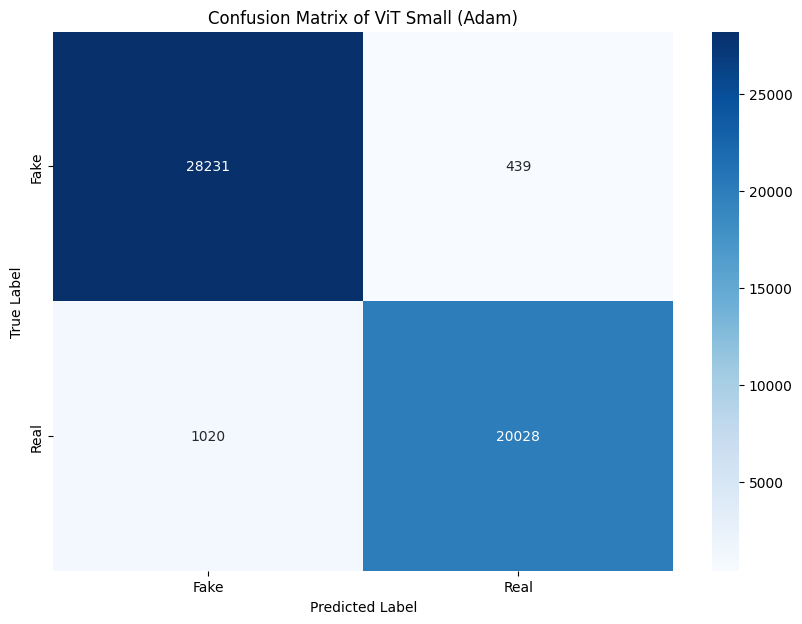

In [20]:
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix of ViT Small (Adam)')
plt.show()

In [21]:
torch.save(vit_model.state_dict(), 'vit_small_patch16_224_10_epochs_balanced_adam.pth')